# FrozenLake [8x8 | random map | no slip]

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import cv2
from PIL import Image

plt.style.use(['dark_background', 'seaborn-v0_8'])

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


In [11]:
class FrozenLakeImageWrapper(gym.ObservationWrapper):
    def __init__(self, env, img_size=(84, 84), grayscale=False):
        super().__init__(env)
        self.img_size = img_size
        self.grayscale = grayscale
        channels = 1 if grayscale else 3
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(*img_size, channels),
            dtype=np.uint8
        )

    def observation(self, _):
        frame = self.env.render()
        if frame is None:
            channels = 1 if self.grayscale else 3
            return np.zeros((*self.img_size, channels), dtype=np.uint8)

        # Convert to PIL Image
        img = Image.fromarray(frame)

        # Grayscale conversion
        if self.grayscale:
            img = img.convert('L')

        # Resize
        img = img.resize(self.img_size, Image.NEAREST)
        obs = np.array(img, dtype=np.uint8)

        # Add channel dimension for grayscale
        if self.grayscale:
            obs = np.expand_dims(obs, axis=-1)

        return obs


def preprocess_frame(frame, resize=(84, 84), grayscale=True):
    """For testing preprocessing"""
    img = Image.fromarray(frame)
    if grayscale:
        img = img.convert('L')
    img = img.resize(resize, Image.NEAREST)
    return np.array(img)

In [12]:
class RandomMapResetWrapper(gym.Wrapper):
    def __init__(self, env, size=8, p=0.8):
        super().__init__(env)
        self.size = size
        self.p = p
        self.current_desc = None  # <-- new field

    def reset(self, **kwargs):
        new_desc = generate_random_map(size=self.size, p=self.p)
        self.current_desc = tuple(new_desc)  # hashable
        self.env = gym.make(
            "FrozenLake-v1",
            desc=new_desc,
            is_slippery=self.env.spec.kwargs.get("is_slippery", True),
            render_mode=self.env.render_mode
        )
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [13]:
class FrozenLakeCNN(nn.Module):
    def __init__(self, action_size, grayscale=True):
        super().__init__()
        self.grayscale = grayscale
        channels = 1 if grayscale else 3

        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate feature size: ((84-8)//4 + 1) = 20 → ((20-4)//2 +1)=9 → (9-3+1)=7
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        # x shape: (B, H, W, C) → (B, C, H, W)
        x = x.permute(0, 3, 1, 2).float() / 255.0
        return self.fc(self.conv(x))

In [14]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [15]:
class DQNAgent:
    def __init__(self, modelClass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=100):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Q-network and target network
        self.q_net = modelClass(state_size, action_size).to(device)
        self.target_net = modelClass(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Sync target network
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


In [16]:
def create_env(render_mode=None, use_image=False, img_size=(84, 84), grayscale=True, random_map_every_reset=True):
    # Start with a dummy env to get action space, but we’ll replace it on first reset
    env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode=render_mode)
    if random_map_every_reset:
        env = RandomMapResetWrapper(env, size=8)
    if use_image:
        env = FrozenLakeImageWrapper(env, img_size=img_size, grayscale=grayscale)
        state_shape = (*img_size, 1 if grayscale else 3)
    else:
        # For non-image mode, you’d also need to handle dynamic state space,
        # but since you're using image mode, we focus on that.
        state_shape = env.observation_space.n
    action_size = env.action_space.n
    return env, state_shape, action_size


def train_dqn(agent, env, state_shape, action_size,
              episodes=2000,
              max_steps=100,
              epsilon_start=1.0,
              epsilon_end=0.01,
              epsilon_decay=0.995, ):
    global history_rewards, history_epsilons

    scores = deque(maxlen=100)
    recent_maps = deque(maxlen=100)

    epsilon = epsilon_start
    print("Starting training...")

    for episode in range(episodes):
        state, _ = env.reset()
        # state is now image - no one-hot needed
        total_reward = 0

        current_map = getattr(env.env, 'current_desc', None)
        recent_maps.append(current_map)

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # FIXED REWARD SHAPING (preserve original reward)
            original_reward = reward
            if not truncated and terminated:
                if original_reward == 1.0:  # GOAL
                    shaped_reward = 1.0
                else:  # HOLE
                    shaped_reward = -1.0
            else:
                shaped_reward = original_reward - 0.01  # Gentle penalty

            agent.remember(state, action, shaped_reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += shaped_reward

            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        history_rewards.append(np.mean(scores))
        history_epsilons.append(epsilon)

        if episode % 100 == 0:
            unique_maps = len(set(m for m in recent_maps if m is not None))
            print(f"Episode {episode}, Avg Reward: {np.mean(scores):.3f}, "
                  f"Epsilon: {epsilon:.3f}, Unique Maps (last 100): {unique_maps}")

        if episode % 1500 == 0 and episode > 0:
            render_env, _, _ = create_env(render_mode="human", use_image=True, random_map_every_reset=True)
            evaluate_agent(agent, render_env, episodes=2, no_log=True)
            render_env.close()

    return agent, env


def evaluate_agent(agent, env, episodes=10, max_steps=1000, no_log=False):
    """
    Evaluate agent on pixel-based environment.
    - Works with both image and discrete state spaces
    """
    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        for step in range(max_steps):
            action = agent.act(state, epsilon=0.0)  # Greedy policy
            state, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated:
                if reward == 1.0:  # Reached goal
                    success += 1
                break

    if not no_log:
        print(f"\nSuccess rate: {success}/{episodes} ({100 * success / episodes:.1f}%)")
    return success


def act(self, state, epsilon=0.0):
    if random.random() < epsilon:
        return random.randrange(self.action_size)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = self.q_net(state_tensor)
    return q_values.argmax().item()

## training loop

In [17]:
grayscale = True  # Set to False for RGB
img_size = (84, 84)

_, _, action_size = create_env(use_image=False)
env, state_shape, _ = create_env(render_mode="rgb_array", use_image=True,
                                 img_size=img_size, grayscale=grayscale)

agent = DQNAgent(
    modelClass=lambda s, a: FrozenLakeCNN(a, grayscale=grayscale),
    state_size=None,  # Not used
    action_size=action_size,
    lr=5e-5,
    gamma=0.999,
    buffer_size=50_000,
    batch_size=64,
    target_update=10
)

history_rewards, history_epsilons = [], []

Starting training...
Episode 0, Avg Reward: -1.130, Epsilon: 1.000, Unique Maps (last 100): 1
Episode 100, Avg Reward: -1.131, Epsilon: 0.951, Unique Maps (last 100): 100
Episode 200, Avg Reward: -1.131, Epsilon: 0.904, Unique Maps (last 100): 100
Episode 300, Avg Reward: -1.131, Epsilon: 0.860, Unique Maps (last 100): 100
Episode 400, Avg Reward: -1.113, Epsilon: 0.818, Unique Maps (last 100): 100
Episode 500, Avg Reward: -1.106, Epsilon: 0.778, Unique Maps (last 100): 100
Episode 600, Avg Reward: -1.107, Epsilon: 0.740, Unique Maps (last 100): 100
Episode 700, Avg Reward: -1.066, Epsilon: 0.704, Unique Maps (last 100): 100
Episode 800, Avg Reward: -1.106, Epsilon: 0.670, Unique Maps (last 100): 100
Episode 900, Avg Reward: -1.068, Epsilon: 0.637, Unique Maps (last 100): 100
Episode 1000, Avg Reward: -1.114, Epsilon: 0.606, Unique Maps (last 100): 100
Episode 1100, Avg Reward: -1.091, Epsilon: 0.577, Unique Maps (last 100): 100
Episode 1200, Avg Reward: -1.038, Epsilon: 0.548, Unique 

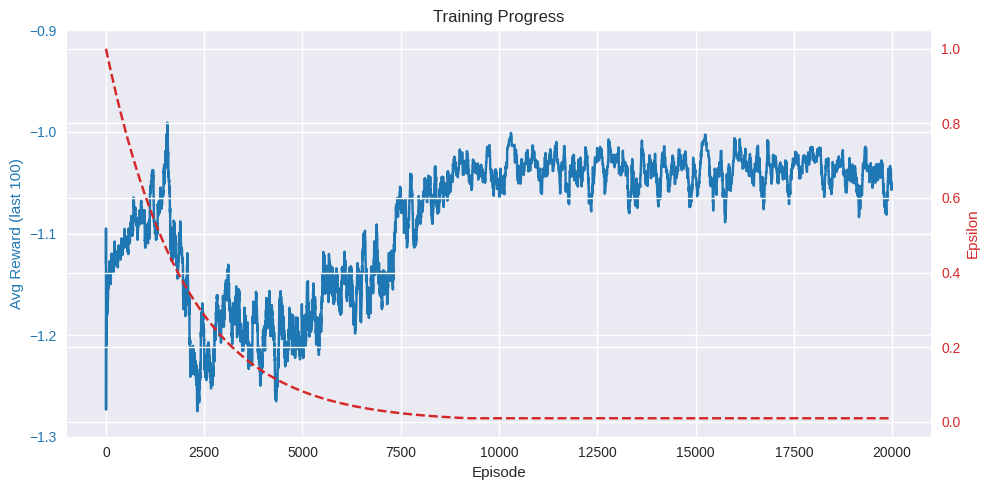

In [18]:
try:
    agent, env = train_dqn(
        agent=agent,
        env=env,
        state_shape=state_shape,
        action_size=action_size,
        episodes=20_000,
        max_steps=1000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.9995,
    )
finally:
    # Plotting code (unchanged)
    print(f"Model: {FrozenLakeCNN.__name__}")
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Avg Reward (last 100)', color=color)
    ax1.plot(history_rewards, color=color, label='Avg Reward')
    ax1.tick_params(axis='y', labelcolor=color)

    if len(history_rewards) > 0:
        y_min = np.floor(min(history_rewards) * 10) / 10
        y_max = np.ceil(max(history_rewards) * 10) / 10
        ax1.set_yticks(np.arange(y_min, y_max + 0.05, 0.1))

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Epsilon', color=color)
    ax2.plot(history_epsilons, color=color, label='Epsilon', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Progress')
    fig.tight_layout()
    plt.show()

In [ ]:
eval_env, _, _ = create_env(render_mode="human", use_image=True, random_map_every_reset=True)
evaluate_agent(agent, eval_env, episodes=5)
eval_env.close()